# Анализ поведения пользователей приложения "Ненужные вещи"

## Описание проекта:
 В мобильном приложении "Ненужные вещи"пользователи продают свои ненужные вещи, размещая их на доске объявлений. Пользователь находят через рекомендательную, либо поисковую систему нужный ему товар, созванивается с продавцом и договаривется о факте продажи товара.

## Заказчик:
продакт-менеджер, который занимается продвижением данного приложения как продукта

## Цель исследования:
проанализировать поведение пользователей приложения. Определить, как клиенты используют его, какие сценарии есть событий, какие есть характерные черты у тех, кто совершает целевое действие, и кто не совершает

## Задачи исследования:
*   определить, какие события влияют на конверсию в целевое действие
*   исследовать, какие сценарии использования приложения выделяются

## 1. Предобработка данных

In [1]:
# импортируем библиотеки
import pandas as pd
import scipy.stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
import math as mth
from statsmodels.stats.multitest import multipletests
from numpy import median
import requests
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
# конвертеры, которые позволяют использовать типы pandas в matplotlib
register_matplotlib_converters()

In [2]:
#задаем размеры графиков
sns.set(rc={'figure.figsize':(12,6)})
# определяем палитру
sns.set_palette('pastel')
# задаем стиль графиков
sns.set_style('whitegrid')

In [3]:
# загружаем данные
sources, events = (
    pd.read_csv('/content/mobile_sourсes.csv'),
    pd.read_csv('/content/mobile_dataset.csv'),
    )

In [4]:
# изучим основную информацию о данных, проверим на пропуски идубликаты
def data_info(data):
    return (display(data.head()),
           data.info(),
           data.isna().sum(),
           data.duplicated().sum(),
           round((data.duplicated().sum()) / len(data) * 100, 2))

In [5]:
data_info(sources)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


(None,
 None,
 userId    0
 source    0
 dtype: int64,
 0,
 0.0)

In [6]:
data_info(events)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


(None,
 None,
 event.time    0
 event.name    0
 user.id       0
 dtype: int64,
 0,
 0.0)

In [7]:
#приведем названия столбцов к хорошему стилю
sources.columns = ['user_id', 'source']
events.columns = ['time', 'event', 'user_id']

In [8]:
# преобразование данных о времени
events['time'] = pd.to_datetime(events['time'])

Пропусков и явных дубликатов в данных нет. Названия столбцов приведены к хорошему стилю. Столбец с датой и временем приведен к соответствующему типу. Данные подготовлены к анализу.

## 2. Исследовательский анализ данных

In [9]:
# количество уникальных пользователей
print('Общее количество пользователей в логе:', events['user_id'].nunique())

Общее количество пользователей в логе: 4293


In [10]:
# сколько всего событий в логе
print('Общее количество событий в логе:', events.shape[0])

Общее количество событий в логе: 74197


In [11]:
#какие события представлены
events['event'].sort_values().unique()

array(['advert_open', 'contacts_call', 'contacts_show', 'favorites_add',
       'map', 'photos_show', 'search_1', 'search_2', 'search_3',
       'search_4', 'search_5', 'search_6', 'search_7', 'show_contacts',
       'tips_click', 'tips_show'], dtype=object)




*   Contacts_show и show_contacts - это, очевидно, одно и то же событие. Объединим их в одно.
*   Так как у нас нет детального описания действий пользователей, связанных с поиском по сайту, search_1 - search_7, объеденим их в одно действие search



In [12]:
# переименовываем show_contacts в contacts_show
events['event'] = events['event'].replace('show_contacts', 'contacts_show')

In [13]:
# search_1- search_7 меняем на search
events['event'] = events['event'].str.replace('search_+\d', 'search', regex=True)

In [14]:
events['event'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search',
       'tips_click', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

У нас 9 видов событий: advert_open, tips_show, map, contacts_show, search, tips_click, photos_show, favorites_add, contacts_call

In [15]:
# сколько в среднем событий приходится на пользователя
print('Среднее количество событий на пользователя: %d.' % (events.shape[0]
                                                    / events['user_id'].nunique()))

Среднее количество событий на пользователя: 17.


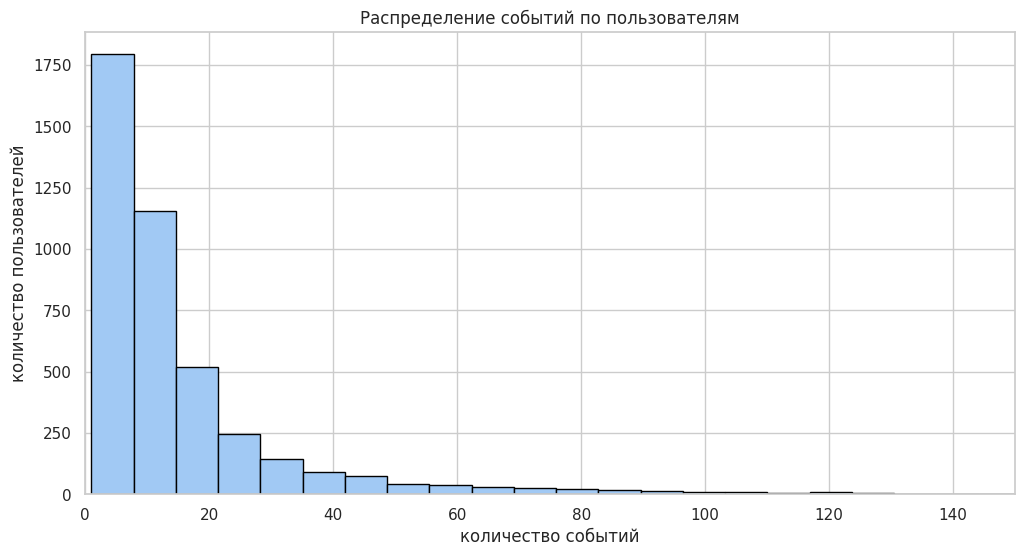

In [16]:
# строим гистограмму кол-ва событий по пользователям
events.groupby('user_id')['event'].count().hist(bins=70, ec='black')
plt.title('Распределение событий по пользователям')
plt.xlabel('количество событий')
plt.ylabel('количество пользователей')
plt.xlim(0, 150);

In [17]:
events.groupby('user_id')['event'].count().describe()

count    4293.000000
mean       17.283252
std        29.130677
min         1.000000
25%         5.000000
50%         9.000000
75%        17.000000
max       478.000000
Name: event, dtype: float64

Минимальное количество событий 1, есть пользователи, которые совершили больше 100 событий, но их очень немного. В среднем совершают 17 событий, а 50% пользователей осуществляют 9 событий. Чтобы не нарушать целостность эксперимента, не будем удалять слишком активных пользователей.

In [18]:
 # определяем максимальную и минимальную дату
events.agg({'time':[min, max]})

,time
min,2019-10-07 00:00:00.431357
max,2019-11-03 23:58:12.532487


Мы распологаем данными с 7 октября 2019 по 3 ноября 2019, то есть почти за месяц использования приложения

In [19]:
# добавим отдельный столбец с датой
events['date'] = pd.to_datetime(events['time'].dt.date)

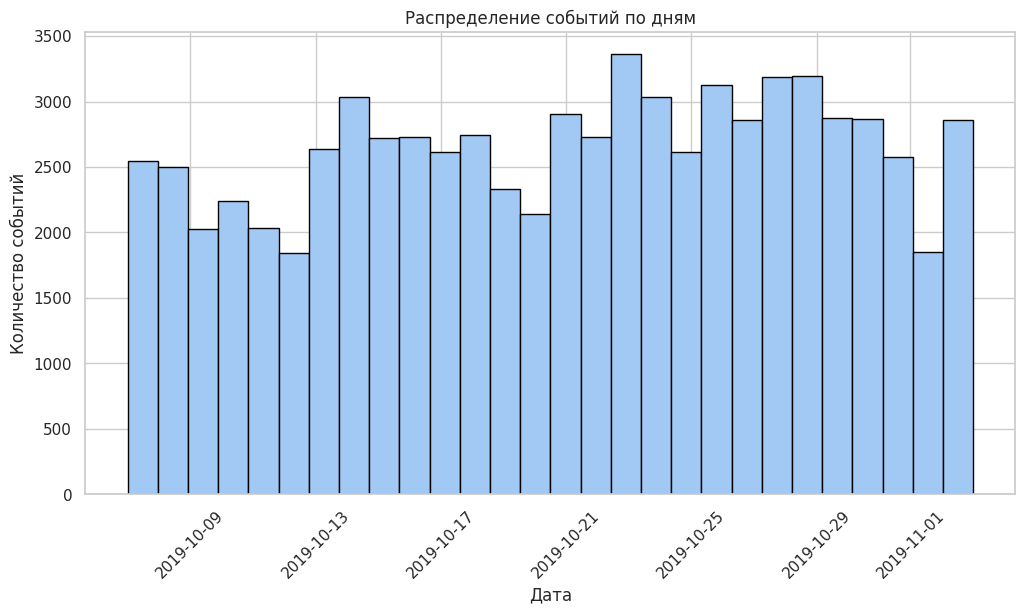

In [20]:
# график распределения событий по дням
events['date'].hist(bins=28, ec='black')
plt.title('Распределение событий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45);

В течении периода исследования количество событий в день колебалось, но не падало ниже примерно 1900 событий в день, в определенные дни достигало более 3000. Очень резких спадов или всплесков не было.

In [21]:
# посмотрим, какие события есть в логах, сколько их
(events
    .pivot_table(index='event', values='user_id', aggfunc='count')
      .sort_values('user_id', ascending=False)
)

,user_id
event,
tips_show,40055
photos_show,10012
search,6784
advert_open,6164
contacts_show,4529
map,3881
favorites_add,1417
tips_click,814
contacts_call,541


Действие tips_show самое популярное, за ним следует photos_show, search и advert_open. Целевое действие contacts_show осуществилось 4529 раз

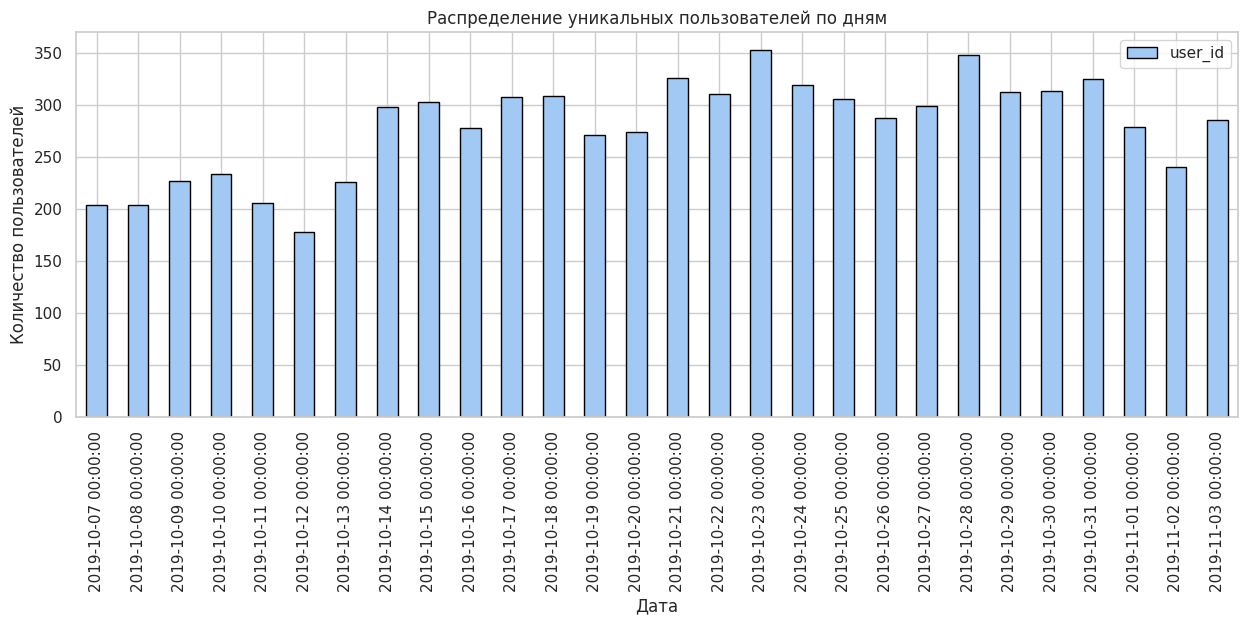

In [22]:
# количество уникальных пользователей по дням, график
events.pivot_table(index='date', values='user_id', aggfunc='nunique').plot(kind='bar', y='user_id', figsize=(15, 5), ec='black')
plt.title('Распределение уникальных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей');


Количество уникальных пользователей в день с небольшими колебаниями растет со второй недели

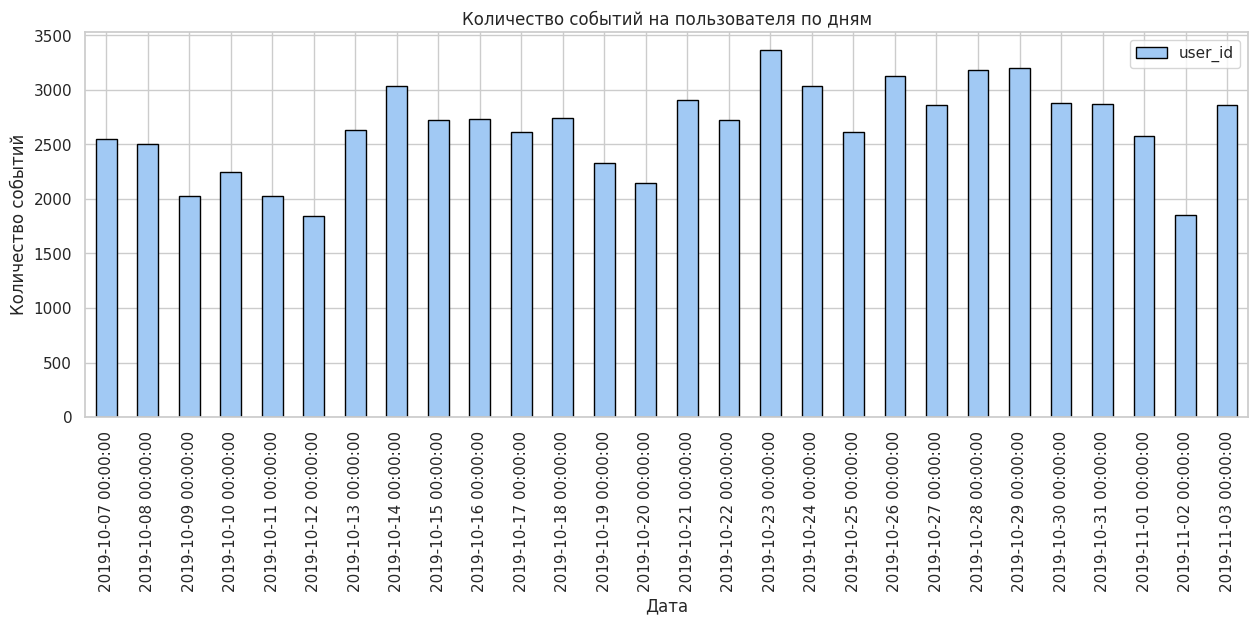

In [23]:
# распределение событий на пользователя по дням
events.pivot_table(index='date', values='user_id', aggfunc='count').plot(kind='bar', y='user_id', figsize=(15, 5), ec='black')
plt.title('Количество событий на пользователя по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий');

Также резких всплесков и падений нет, но наблюдаются колебания. В основном 2000 и более событий в день на пользователя.
> Стоит отметить снижение 2019-11-02 как по количеству событий, так и по количеству пользователей и количеству событий на пользователя

In [24]:
# действия, которые совершали уникальные пользователи, совершившие целевое действие
target = (
         events[events['user_id'].isin(events.query('event == "contacts_show"')['user_id']
         .unique())].reset_index(drop=True)
)

In [25]:
# количество уникальных пользователей по событиям
fnl2= (events
     .pivot_table(index='event', values='user_id', aggfunc='nunique')
     .reset_index()
)
fnl2.columns = ['event', 'users']

In [26]:
# переходы в целевое действие с разных этапов
fnl= (target
     .pivot_table(index='event', values='user_id', aggfunc='nunique')
     .reset_index()
)
fnl.columns = ['event', 'users']
fnl['share'] = round(fnl['users'] / fnl2['users'] * 100, 2)
fnl['loss'] = 100 - fnl['share']
fnl = fnl.sort_values('share', ascending=False)

In [27]:
fnl

,event,users,share,loss
1,contacts_call,213,100.00,0.00
2,contacts_show,981,100.00,0.00
3,favorites_add,136,38.75,61.25
7,tips_click,100,31.06,68.94
5,photos_show,339,30.96,69.04
6,search,377,22.63,77.37
4,map,289,19.85,80.15
8,tips_show,516,18.42,81.58
0,advert_open,138,18.38,81.62


Все пользователи, которые звонили продавцам, заходили в контакты, что логично.  981 пользователь осуществил целевое действие. Топ 3 этапов с которых переходят в контакты: добавление в избранное, клик по рекомендованному объявлению, просмотр фото. Меньше всего из карточки объявления.

### Создадим сценарии поведения пользователей

In [28]:
events = events.sort_values(['user_id', 'time']).reset_index(drop=True)

In [29]:
# считаем время между событиями
events['diff'] = round(events.groupby('user_id')['time'].diff().dt.total_seconds().fillna(0) / 60, 2)

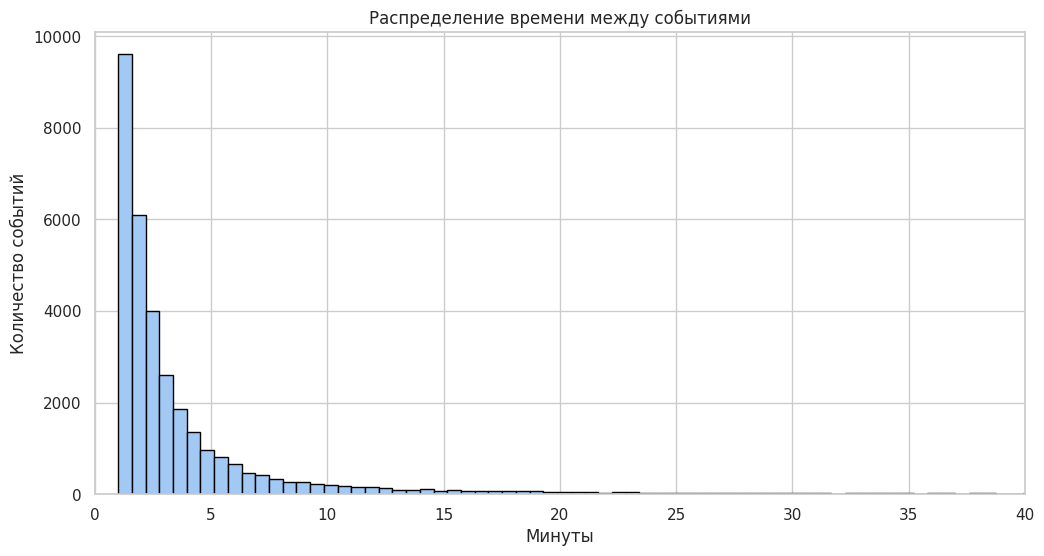

In [30]:
# график распределения времени между событиями
events['diff'].hist(bins=100, range=(1, 60), ec='black')
plt.xlim(0, 40)
plt.title('Распределение времени между событиями')
plt.xlabel('Минуты')
plt.ylabel('Количество событий');
plt.ticklabel_format(axis='x',style='plain');

In [31]:
events['diff'].describe()

count    74197.000000
mean       219.537099
std       1488.939287
min          0.000000
25%          0.270000
50%          1.060000
75%          2.790000
max      38269.910000
Name: diff, dtype: float64

В основном время между событиями составляет до 20 минут, есть пользователи у которых доходит до 30 минут. Очень большая разница во времени, скорее всего, у пользователей, которые редко используют приложение, тем не менее они его используют, поэтому мы не будем их удалять. Стандартно тайм-аут также устанавливают от 30 минут, что мы и сделаем.


In [32]:
# датафрейм для сессий
sessions = events.sort_values(['user_id', 'time']).reset_index(drop=True)

In [33]:
# установим тайм-аут 30 минут
g = (sessions.groupby('user_id')['time'].diff() > pd.Timedelta('30Min')).cumsum()
# создаем счетчик групп
sessions['session_id'] = sessions.groupby(['user_id', g], sort=False).ngroup() + 1
sessions

,time,event,user_id,date,diff,session_id
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0.00,1
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0.75,1
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0.58,1
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2.25,1
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2.17,1
...,...,...,...,...,...,...
74192,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,0.46,10368
74193,2019-11-03 15:51:57.899997,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,0.57,10368
74194,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,15.72,10368
74195,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,0.62,10368


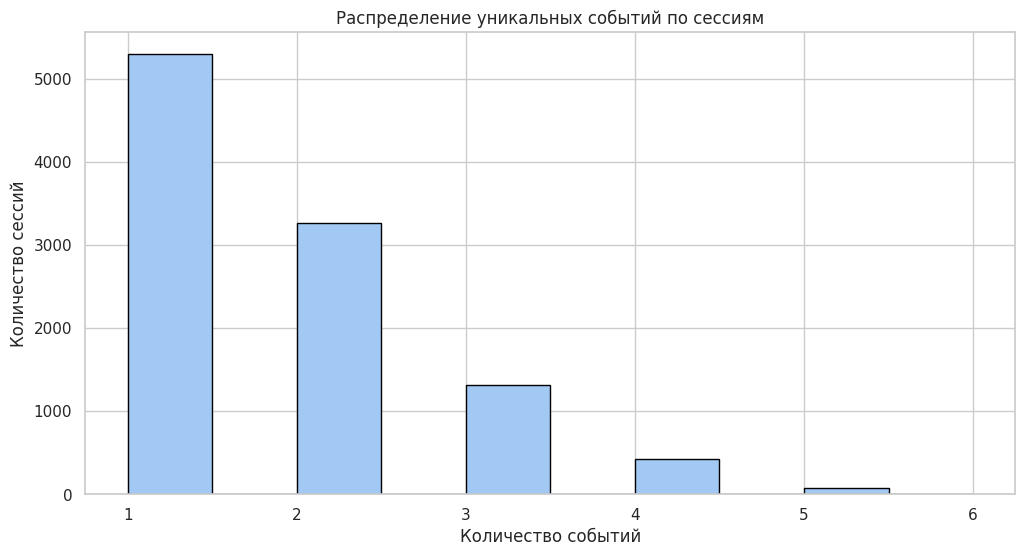

In [34]:
# посмотрим, сколько шагов проходит пользователь за сессию
sessions.groupby('session_id')['event'].nunique().hist(ec='black')
plt.title('Распределение уникальных событий по сессиям')
plt.xlabel('Количество событий')
plt.ylabel('Количество сессий');

In [35]:
# среднее количество сессий на пользователя
print('Среднее количество сессий на пользователя:', round(sessions.groupby('user_id')['session_id'].nunique().mean(), 0))

Среднее количество сессий на пользователя: 2.0


В среднем на пользователя приходится 2 сессии. Количество уникальных шагов за сессию от 1 до 5.

In [36]:
# начало и конец сессии
ses_dur= sessions.groupby(['user_id', 'session_id']).agg({'time':['first', 'last']}).reset_index()
ses_dur.columns = ['user_id', 'session_id', 'first', 'last']

In [37]:
# длительность сессий
ses_dur['duration'] = round((ses_dur['last'] - ses_dur['first']).dt.total_seconds()/60, 2)

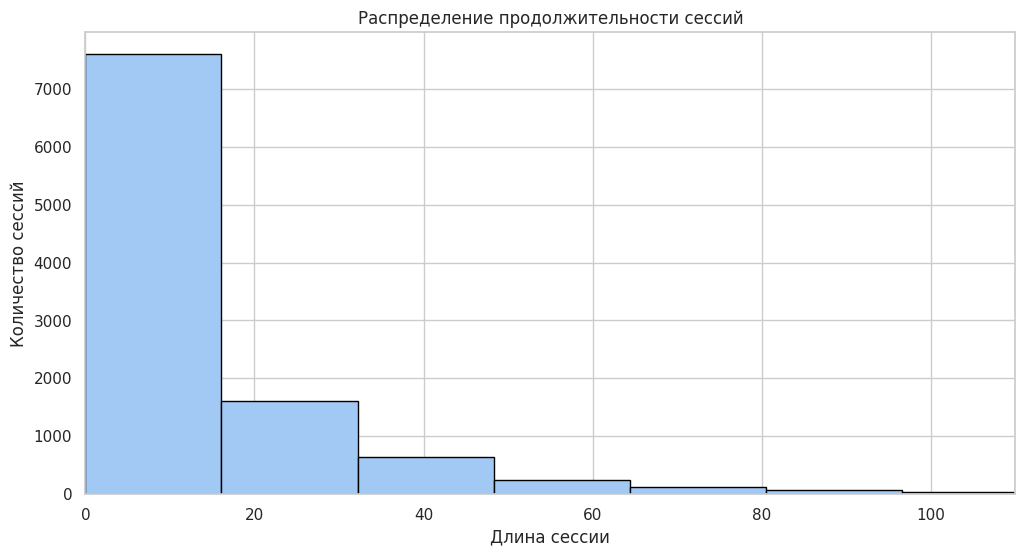

In [38]:
# график распределения длительности сессий
ses_dur['duration'].hist(bins=20, ec='black')
plt.xlim(0, 110)
plt.title('Распределение продолжительности сессий')
plt.xlabel('Длина сессии')
plt.ylabel('Количество сессий')
plt.ticklabel_format(axis='x',style='plain');

In [39]:
ses_dur['duration'].describe()

count    10368.000000
mean        12.877825
std         19.860204
min          0.000000
25%          0.350000
50%          5.590000
75%         17.422500
max        321.970000
Name: duration, dtype: float64

В среднем длительность сессии составляет 12 минут. Есть также и нулевые сессии.

In [40]:
# добавляем столбец с длительностью сессии
sessions2 = sessions.merge(ses_dur, on='session_id', how='left')

In [41]:
# средняя и медианная длина сессии для тех, кто совершил целевое действие
sessions2.query('event == "contacts_show"').agg({'duration':['mean', 'median']})

,duration
mean,36.602058
median,21.960000


In [42]:
# средняя и медианная длина сессии для тех, кто не совершал целевое действие
sessions2.query('event != "contacts_show"').agg({'duration':['mean', 'median']})

,duration
mean,32.369056
median,21.060000


Как видим, медианная длина сессии для пользователей совершивших целевое и действие, и для тех, кто его не совершал, почти не различаются. Средняя длина сессии у тех, кто смотрел контакты, примерно, на 4 минуты дольше.

In [43]:
# отберем сессии с нулевой продолжительностью
bad_ses = sessions2[sessions2['session_id'].isin(ses_dur.query('duration == 0')['session_id'])]

In [44]:
print('Количество и доля нулевых сессий:', len(bad_ses),',',round(len(bad_ses) / len(sessions), 2))

Количество и доля нулевых сессий: 2205 , 0.03


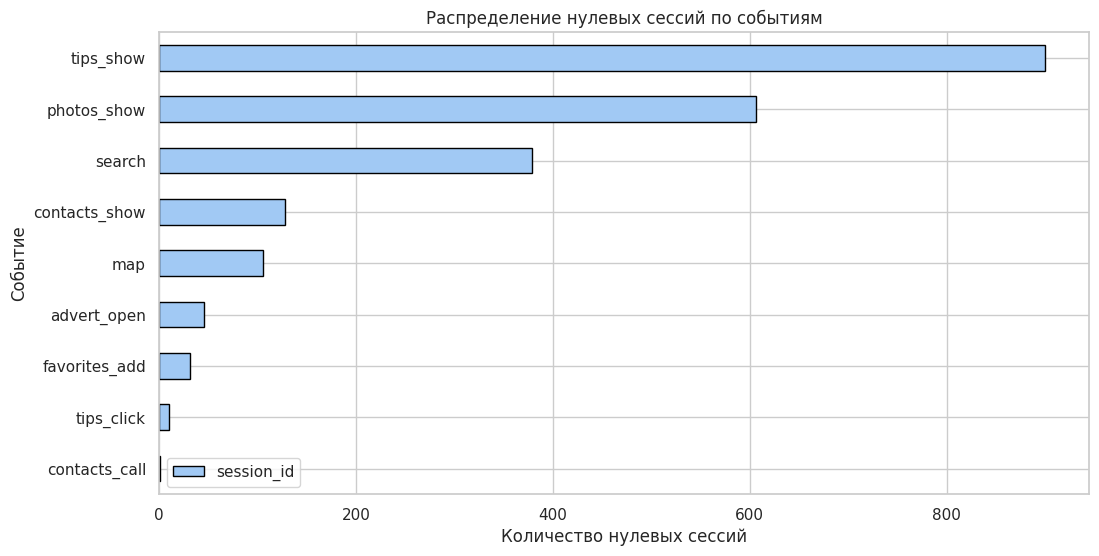

In [45]:
# график распределения нулевых сессий по событиям
bad_ses.groupby('event').count().sort_values('session_id').plot(kind='barh', y='session_id', ec='black')
plt.title('Распределение нулевых сессий по событиям')
plt.xlabel('Количество нулевых сессий')
plt.ylabel('Событие')
plt.ticklabel_format(axis='x',style='plain');

Доля нулевых сессий небольшая, менее 1%. Это пользователи, которые совершили 1 событие, тем не менее, они использовали приложение, и среди нулевых сессий есть целевое действие, поэтом их не будем удалять.

### Для определения наиболее популярных сценариев поведения пользователей построим диаграмму Санкея

In [46]:
def add_features(df):

    """Функция генерации новых столбцов для исходной таблицы

    Args:
        df (pd.DataFrame): исходная таблица.
    Returns:
        pd.DataFrame: таблица с новыми признаками.
    """

    # сортируем по id и времени
    sorted_df = df.sort_values(by=['session_id', 'time']).copy()
    # добавляем шаги событий
    sorted_df['step'] = sorted_df.groupby('session_id').cumcount() + 1

    # добавляем узлы-источники и целевые узлы
    # узлы-источники - это сами события
    sorted_df['source'] = sorted_df['event']
    # добавляем целевые узлы
    sorted_df['target'] = sorted_df.groupby('session_id')['source'].shift(-1)
    # убираем повторяющиеся события
    sorted_df = sorted_df.query('source != target')
    # возврат таблицы без имени событий
    return sorted_df.drop(['event'], axis=1)

# преобразуем таблицу
sessions = add_features(sessions)
sessions.head()

,time,user_id,date,diff,session_id,step,source,target
8,2019-10-07 13:49:41.716617,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2.15,1,9,tips_show,NaN
10,2019-10-09 18:35:28.260975,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,1.54,2,2,map,tips_show
12,2019-10-09 18:42:22.963948,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,1.90,2,4,tips_show,NaN
14,2019-10-21 19:53:17.165009,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,0.77,3,2,tips_show,map
15,2019-10-21 19:53:38.767230,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,0.36,3,3,map,tips_show


In [47]:
# удалим все пары source-target, шаг которых превышает 5
# и сохраним полученную таблицу в отдельную переменную
df_comp = sessions[sessions['step'] <= 5].copy().reset_index(drop=True)

In [48]:
def get_source_index(df):

    """Функция генерации индексов source

    Args:
        df (pd.DataFrame): исходная таблица с признаками step, source, target.
    Returns:
        dict: словарь с индексами, именами и соответсвиями индексов именам source.
    """

    res_dict = {}

    count = 0
    # получаем индексы источников
    for no, step in enumerate(df['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = df[df['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1

    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict


# создаем словарь
source_indexes = get_source_index(df_comp)

In [49]:
def colors_for_sources(mode):

    """Генерация цветов rgba

    Args:
        mode (str): сгенерировать случайные цвета, если 'random', а если 'custom' -
                    использовать заранее подготовленные
    Returns:
        dict: словарь с цветами, соответствующими каждому индексу
    """
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}

    if mode == 'random':
        # генерим случайные цвета
        for label in df_comp['source'].unique():
            r, g, b = np.random.randint(255, size=3)
            colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'

    elif mode == 'custom':
        # присваиваем ранее подготовленные цвета
        colors = requests.get('https://raw.githubusercontent.com/rusantsovsv/senkey_tutorial/main/json/colors_senkey.json').json()
        for no, label in enumerate(df_comp['source'].unique()):
            colors_dict[label] = colors['custom_colors'][no]

    return colors_dict


# генерю цвета из своего списка
colors_dict = colors_for_sources(mode='custom')

In [50]:
def percent_users(sources, targets, values):

    """
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)

    Args:
        sources (list): список с индексами source.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.

    Returns:
        list: список с "объемами" потоков в процентах
    """

    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))

    new_list = []

    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}

    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl

    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))

    return new_list

In [51]:
def lists_for_plot(source_indexes=source_indexes, colors=colors_dict, frac=10):

    """
    Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем
    их в виде словаря

    Args:
        source_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами source.
        frac (int): ограничение на минимальный "объем" между узлами.

    Returns:
        dict: словарь со списками, необходимыми для диаграммы.
    """

    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # проходим по каждому шагу
    for step in tqdm_notebook(sorted(df_comp['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in tqdm_notebook(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id
                temp_df = df_comp[(df_comp['step'] == step)&(df_comp['source'] == source)&(df_comp['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))

    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])

    # посчитаем проценты всех потоков
    perc_values = percent_users(sources, targets, values)

    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")

    # возвратим словарь с вложенными списками
    return {'sources': sources,
            'targets': targets,
            'values': values,
            'labels': labels,
            'colors_labels': colors_labels,
            'link_color': link_color,
            'link_text': link_text}


# создаем словарь
data_for_plot = lists_for_plot()

Шаг:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [52]:
def plot_senkey_diagram(data_dict=data_for_plot):

    """
    Функция для генерации объекта диаграммы Сенкей

    Args:
        data_dict (dict): словарь со списками данных для построения.

    Returns:
        plotly.graph_objs._figure.Figure: объект изображения.
    """

    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text="Sankey Diagram", font_size=10, width=1000, height=600)

    # возвращаем объект диаграммы
    return fig


# сохраняем диаграмму в переменную
senkey_diagram = plot_senkey_diagram()

In [53]:
senkey_diagram.show()

Наиболее популярные сценарии, которые ведут к целевому дествию:


*   map - tips_show - contacts_show
*   tips_show - contacts_show
*   search - photos_show - contacts_show



### Построим воронки по событиям этих сценариев

In [54]:
# пользователи, совершившие событие map
map_users = events.query('event == "map"')['user_id'].unique()

In [55]:
# пользователи, совершившие событие tips_show из тех, кто совершил map
map = events.query('event == "tips_show" and user_id in @map_users')['user_id'].unique()

In [56]:
# пользователи, совершившие contacts_show из тех, кто совершил tips_show
contacts_show = events.query('event == "contacts_show" and user_id in @map')['user_id'].unique()

In [57]:
# создаем датафрейм
first_fnl = pd.DataFrame(columns = ['event', 'users'], data = [
    ['map', len(map_users)],
    ['tips_show', len(map)],
    ['contacts_show', len(contacts_show)]
])

In [58]:
# строим воронку
fig = go.Figure(go.Funnel(
    y = first_fnl['event'],
    x = first_fnl['users'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.7, marker = {"color": ["deepskyblue", "lightsalmon", "tan"],
    "line": {"width": [4, 2, 2, 3, 1], "color": ["wheat", "wheat","blue"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_text='Воронка по сценарию map - tips_show - contacts_show')

fig.show()

Пользователи хорошо конвертируются со страницы карты в просмотр рекомендованных объявлений (93%), но из них до целевого действия доходят 19%

In [59]:
# пользователи, совершившие tips_show
tips_show = events.query('event == "tips_show"')['user_id'].unique()

In [60]:
# пользователи, совершившие contacts_show из тех, кто совершил tips_show
tips_show2 = events.query('event == "contacts_show" and user_id in @tips_show')['user_id'].unique()

In [61]:
# создаем датафрейм
second_fnl = pd.DataFrame(columns = ['event', 'users'], data = [
    ['tips_show', len(tips_show)],
    ['contacts_show', len(tips_show2)]
])

In [62]:
# строим воронку
fig = go.Figure(go.Funnel(
    y = second_fnl['event'],
    x = second_fnl['users'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.7, marker = {"color": ["deepskyblue", "lightsalmon"],
    "line": {"width": [4, 2, 2, 3, 1], "color": ["wheat", "blue"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_text='Воронка по сценарию tips_show - contacts_show')

fig.show()

С 1го шага "просмотр рекомедованных объявлений" из 2801 пользователя в показ контактов переходит 516, то есть 18%

In [63]:
# пользователи, совершившие действие search
search = events.query('event == "search"')['user_id'].unique()

In [64]:
# пользователи, перешедшие в photos_show, из search
search2 = events.query('event == "photos_show" and user_id in @search')['user_id'].unique()

In [65]:
# пользователи, перешедшие в contacts_show, из photas_show
search3 = events.query('event == "contacts_show" and user_id in @search2')['user_id'].unique()

In [66]:
# создаем датафрейм
third_fnl = pd.DataFrame(columns = ['event', 'users'], data = [
    ['search', len(search)],
    ['photos_show', len(search2)],
    ['contacts_show', len(search3)]
])

In [67]:
# строим воронку
fig = go.Figure(go.Funnel(
    y = third_fnl['event'],
    x = third_fnl['users'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.7, marker = {"color": ["deepskyblue", "lightsalmon", "tan"],
    "line": {"width": [4, 2, 2, 3, 1], "color": ["wheat", "wheat","blue"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_text='search - photos_show - contacts_show')

fig.show()

Из 1666 пользователей, воспользовавшихся поиском, 647, то есть 39% процентов перешли в просмотр фотографий, из них 192, то есть 12% доходит до просмотра контактов.

Итак, мы проанализировали динамику пользователей по дням и событиям. Установили события, влияющие на переход в целевое событие:

*   добавление в избранное
*   клик по рекомендованному объявлению
*   просмотр фото

определили популярные сценарии поведения пользователей:

*   map - tips_show - contacts_show
*   tips_show - contacts_show
*   search - photos_show - contacts_show











## Формулировка и проверка гипотез

### Гипотеза 1:
Одни пользователи совершают действия tips_show и tips_click, другие — только tips_show
    

*   H0: конверсия в просмотры контактов у этих двух групп одинаковая
*   H1: конверсия в просмотры у этих двух групп различается



In [68]:
# пользователи, совершившие действие tips_show
tips_show = events.query('event == "tips_show"')['user_id'].unique()
print('Количество уникальных пользователей, совершивших дествие tips_show:', len(tips_show))

Количество уникальных пользователей, совершивших дествие tips_show: 2801


In [69]:
# пользователи, совершившие оба действия: tips_show и tips_click
show_click = events.query('event == "tips_click" and user_id in @tips_show')['user_id'].unique()
print('Количество уникальных пользователей, совершивших оба действия: tips_show и tips_click:', len(show_click))

Количество уникальных пользователей, совершивших оба действия: tips_show и tips_click: 297


In [70]:
# пользователи, совершившие только действие tips_show
only_show = events.query('event == "tips_show" and user_id not in @show_click')['user_id'].unique()
print('Количество уникальных пользователей, совершивших только действие tips_show:', len(only_show))

Количество уникальных пользователей, совершивших только действие tips_show: 2504


In [71]:
# пользователи, совершившие действие только tips_show и перешедшие в contacts_show
tips_show_cont = events.query('event == "contacts_show" and user_id in @only_show')['user_id'].nunique()
print('Количество уникальных пользователей, совершивших действие tips_show и перешедшие в contacts_show:', tips_show_cont)

Количество уникальных пользователей, совершивших действие tips_show и перешедшие в contacts_show: 425


In [72]:
# пользователи, совершившие оба действия tips_show, tips_click и перешедшие в contacts_show
click_show_cont = events.query('event == "contacts_show" and user_id in @show_click')['user_id'].nunique()
print('Количество уникальных пользователей, совершивших оба действия tips_show, tips_click и перешедшие в contacts_show:', click_show_cont)

Количество уникальных пользователей, совершивших оба действия tips_show, tips_click и перешедшие в contacts_show: 91


Установим уровень статистической значимости 0.05.
> Применим z-test для проверки гипотезы о равенстве долей.

In [73]:
# проверка гипотезы z-test
trials = np.array([len(only_show), len(show_click)])
successes = np.array([tips_show_cont, click_show_cont])
# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]
# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]
# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
# разница пропорций в датасетах
difference = p1 - p2
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
# задаем критический уровень статистической значимости
alpha = 0.05
print('P-value:', p_value)
if (p_value < alpha):
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

P-value: 9.218316554537864e-09
Отвергаем нулевую гипотезу: между долями есть значимая разница


Для данных групп P-value меньше 0.05.
Значит, на имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве между группами.

> Вывод: конверсия в просмотры контактов у тех пользователей, кто совершают действия tips_show и tips_click, и у тех, кто совершает только tips_show различается
    .

### Гипотеза 2:




*   Н0: добавление объявления в избранное не влияет на конверсию в целевое действие

*   Н1: добавление объявления в избранное влияет на конверсию в целевое действие





In [74]:
# пользователи, совершившие действие favorites_add
fav = events.query('event == "favorites_add"')['user_id'].unique()
print('Количество пользователей, совершивших событие favorites_add:', len(fav))

Количество пользователей, совершивших событие favorites_add: 351


In [75]:
# пользователи, совершившие действие favorites_add и contacts_show
fav_contacts = events.query('event == "contacts_show" and user_id in @fav')['user_id'].nunique()
print('Количество пользователей совершивших событие favorites_add и contacts_show:', fav_contacts)

Количество пользователей совершивших событие favorites_add и contacts_show: 136


In [76]:
# пользователи, совершившие действие contacts_show и не совершавшие действие favorites_add
not_fav = events.query('event == "contacts_show" and user_id not in @fav')['user_id'].nunique()
print('Количество пользователей, совершивших только событие contacts_show:', not_fav)

Количество пользователей, совершивших только событие contacts_show: 845


In [77]:
# пользователи, не совершавшие действие favorites_add
users = events.query('user_id not in @fav')['user_id'].nunique()
print('количество пользователей не совершавших событие favorites_add:', users)

количество пользователей не совершавших событие favorites_add: 3942


Установим уровень статистической значимости 0.05.
> Применим z-test для проверки гипотезы о равенстве долей.

In [78]:
# проверка гипотезы z-test
trials = np.array([len(fav), users])
successes = np.array([fav_contacts, not_fav])
# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]
# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]
# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
# разница пропорций в датасетах
difference = p1 - p2
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
# задаем критический уровень статистической значимости
alpha = 0.05
print('P-value:', p_value)
if (p_value < alpha):
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

P-value: 1.3455903058456897e-13
Отвергаем нулевую гипотезу: между долями есть значимая разница


Для данных групп P-value меньше 0.05.
Значит, на имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве между группами.

> Вывод: конверсия в просмотры контактов у тех пользователей, кто совершают действия favorites_add, и у тех, кто его не совершает  различается

## Выводы:


*   Период исследования: с 7 октября 2019 года по 3 ноября 2019

*   Проанализировано поведение 4293 уникальных пользователей приложения "Ненужные вещи"

*   Общее количество событий: 74197, 9 видов событий: advert_open, tips_show, map, contacts_show, search, tips_click, photos_show, favorites_add, contacts_call

*   Среднее количество событий на пользователя: 17

*   В основном у приложения больше 200 уникальных пользователей в день и больше 2000 событий на пользователя в день

*   Установлен тайм-аут 30 минут на основе распределения времени между событиями
*   В целом пользователи проходят 5 уникальных событий за сессию


*   Среднее количество сессий на пользователя: 2

*   Средняя продолжительность сессии с целевым событием 36 минут, без него - 32 минуты






---


*   **События, влияющие на переход в целевое:**
      *   favorites_add
      *   tips_click
      *   photos_show



*   **Наиболее популярные сценарии поведения пользователей, ведущие к целевому действию:**
      *   map - tips_show - contacts_show
      *   tips_show - contacts_show
      *   search - photos_show - contacts_show



---
Есть основания отвергнуть обе выдвинутые гипотезы:

*   конверсия в просмотры контактов у тех пользователей, кто совершают действия tips_show и tips_click, и у тех, кто совершает только tips_show различается
*   конверсия в просмотры контактов у тех пользователей, кто совершают действия favorites_add, и у тех, кто его не совершает  различается










## Рекомендации:


*   Усовершенствовать показ рекламных объявлений и рекомендованных объявлений, проверить таргетированность

*   Пользователям, которые редко пользуются приложением направлять push-уведомления

*   Так как просмотр карты влияет на конверсию, рассмотреть возможность доставки в постаматы по районам
*   Подсвечивать возможность перехода в контакты из любого действия


*   Увеличить количество таргетированной рекламы с целью увеличения количества пользователей




